<a href="https://colab.research.google.com/github/anaghaaaa/Fake-News-Prediction/blob/main/Fake_News_Prediction_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Prediction


## Problem Definition: 

Social network sites (SNSs) have revolutionized the way in which information is spread by allowing users to freely share content. As a consequence, SNSs are also increasingly used as vectors for the diffusion of misinformation and hoaxes. The amount of disseminated information and the rapidity of its diffusion make it practically impossible to assess reliability in a timely manner, highlighting the need for automatic hoax detection systems. Here, we attempt to contribute to current solutions in mitigating the spread of fake news by creating a classifier based on a logistic binary regression commonly prevalent in the field of machine learning and artificial intelligence.  

We use logistic regression, reason being that it can be well used in problems that are large, and uniform set of features. 

## 0. Importing the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Preparing the Data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/datasets/dataset1.csv')

### 1.1 Drop unwanted features & null rows

In [ ]:
df['text'] = df['title'] + df['text']

In [ ]:
df = df.drop(['id', 'title', 'author'], axis=1)
df

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You FiredWhy the Truth...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1
...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",0
20797,Macy’s Is Said to Receive Takeover Approach by...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
df.isnull().sum()

text     597
label      0
dtype: int64

In [ ]:
df = df.dropna() 

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.size

60609

In [ ]:
df.shape

(20203, 3)

### 1.2 Data Visualization

Summary/Breakup of Fake / Real News in Dataset

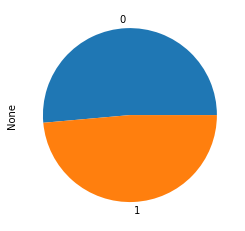

In [ ]:
df.groupby(['label']).size().plot(kind="pie")

**Scatterplot for Length of Article**

**Length of news articles**

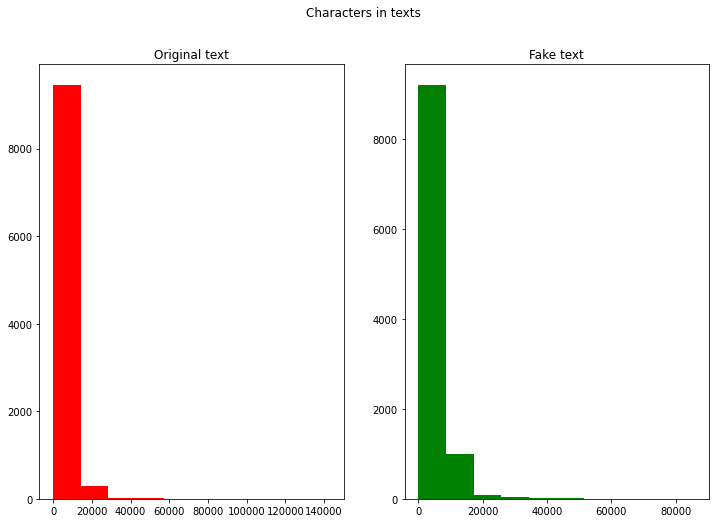

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))

text_len = df[df['label']==1]['text'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')

text_len = df[df['label']==0]['text'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')

fig.suptitle('Characters in texts')
plt.show()

WordCloud

In [ ]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize = (20,20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS)

<Figure size 1440x1440 with 0 Axes>

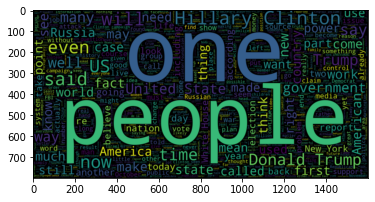

In [ ]:
wc.generate(" ".join(df[df.label==1].text))
plt.imshow(wc , interpolation = 'bilinear')

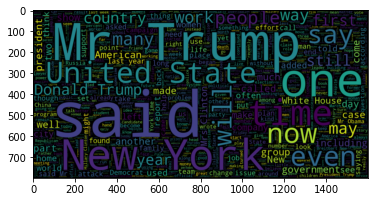

In [ ]:
wc.generate(" ".join(df[df.label==0].text))
plt.imshow(wc , interpolation = 'bilinear')

### 1.3 Text Processing
**Stemming, Lemmatization, Removing Stop Words & Punctuations**

As we are dealing with textual data, there often exists components that might not be of any use to us. We can remove these so that our model can focus on words/components that are determinal to the prediction. Removing it declutter the raw data, and makes it easy & faster to classify & predict.

**Stop Words**

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. These can be removed from our data.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import string

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def nltk_process(data):
    # Tokenization
    tokenList = word_tokenize(data)
    
    # Stemming
    p_stemming = PorterStemmer()
    stemedList = []
    for word in tokenList:
        stemedList.append(p_stemming.stem(word))

    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmaList = []
    for word in stemedList:
        lemmaList.append(wordnet_lemmatizer.lemmatize(word))
        
    # Stopwords
    filtered_words = []
    nltk_stop_words = set(stopwords.words("english"))
    for word in lemmaList:
        if word not in nltk_stop_words:
            filtered_words.append(word)
    
    # Remove punctuation
    for word in filtered_words:
        if word in string.punctuation:
            filtered_words.remove(word)
    
    return filtered_words

In [ ]:
df['text'] = df['text'].apply(lambda x: nltk_process(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 1.2 Vectorize text to numbers

As we know that many Machine Learning algorithms and almost all Deep Learning Architectures are not capable of processing strings or plain text in their raw form. In a broad sense, they require numerical numbers as inputs to perform any sort of task, such as classification, regression, clustering, etc. 

Therefore the strings/words in our textual data need to be encoded as integers or floating point values for use as input to a ML algorithm. This process is called feature extraction (or vectorization). In the NLP world, this is also called Word embeddings.

In [ ]:
# Combining Title & Text of News Article

df['text'] = [" ".join(text) for text in df['text'].values]
X = df['text'].values
print(X)

["hous dem aid We ’ even see comey ’ letter jason chaffetz tweet ithous dem aid We ’ even see comey ’ letter jason chaffetz tweet It By darrel lucu octob 30 2016 subscrib jason chaffetz stump american fork utah imag courtesi michael jolley avail creativ commons-bi licens apolog keith olbermann doubt worst person world thi week–fbi director jame comey accord hous democrat aid look like also know second-worst person well It turn comey sent hi now-infam letter announc fbi wa look email may relat hillari clinton ’ email server rank democrat relev committe ’ hear comey found via tweet one republican committe chairman As know comey notifi republican chairman democrat rank member hous intellig judiciari oversight committe hi agenc wa review email recent discov order see contain classifi inform long thi letter went oversight committe chairman jason chaffetz set polit world ablaz thi tweet fbi dir inform `` fbi ha learn exist email appear pertin investig '' case reopen — jason chaffetz jasonint

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
Y = df['label'].values
print(Y)

[1 0 1 ... 0 1 1]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer.fit(X)

X = vectorizer.transform(X)

In [ ]:
print(X)

  (0, 130964)	0.049406328604422615
  (0, 130878)	0.018961920332165736
  (0, 129867)	0.04424362502212245
  (0, 129863)	0.09494355988553722
  (0, 129782)	0.03749582111914224
  (0, 129729)	0.01125281933856806
  (0, 129111)	0.04781878083472828
  (0, 128413)	0.0383643928876227
  (0, 128085)	0.017087607517731133
  (0, 127993)	0.01253792255270641
  (0, 127896)	0.02926337609115862
  (0, 127801)	0.012814117905381273
  (0, 127651)	0.02246386468190919
  (0, 127569)	0.011732034787298075
  (0, 126784)	0.06065423965579733
  (0, 126575)	0.02578325752311217
  (0, 126498)	0.031392663118152864
  (0, 125346)	0.021589560442841202
  (0, 123821)	0.06566050973268853
  (0, 123035)	0.03329012548230003
  (0, 122749)	0.016379421077788506
  (0, 121888)	0.03829435826582523
  (0, 121168)	0.011029798175804217
  (0, 121153)	0.043071535268344265
  (0, 121083)	0.1377097256418452
  :	:
  (20202, 6427)	0.02778192976606706
  (20202, 6383)	0.03141424248925998
  (20202, 6309)	0.03185672839266944
  (20202, 5299)	0.0178872116

### Creating Test & Training Data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y, random_state=2)

In [ ]:
X_train

<14142x158036 sparse matrix of type '<class 'numpy.float64'>'
	with 3871664 stored elements in Compressed Sparse Row format>

### Comparing Supervised Learning Algorithms

In [ ]:
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10)

In [ ]:
results = []
names = []

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='brute')
knn.fit(X_train, Y_train)


results.append(model_selection.cross_val_score(knn, X_train, Y_train, cv=kfold, scoring='accuracy'))
names.append('KNN')

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

regressor = LogisticRegression()
regressor.fit(X_train, Y_train)

results.append(model_selection.cross_val_score(regressor, X_train, Y_train, cv=kfold, scoring='accuracy'))
names.append('LR')

#### LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train, Y_train)

results.append(model_selection.cross_val_score(svc, X_train, Y_train, cv=2, scoring='accuracy'))
names.append('SVC')

#### Stochastic Gradient Descent (SGD) Learning

 https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, Y_train)

results.append(model_selection.cross_val_score(sgd, X_train, Y_train, cv=2, scoring='accuracy'))
names.append('SGD')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


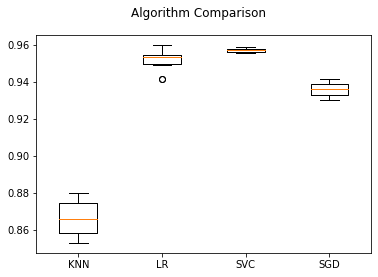

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Unsupervised Learning

In [ ]:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters=2, verbose=1)
clustered = kmeans.fit(X_train)

results.append(model_selection.cross_val_score(kmeans, X_train, Y_train, cv=kfold, scoring='accuracy'))
names.append('kmeans')

Initialization complete
Iteration 0, inertia 27170.76716675912
Iteration 1, inertia 13560.123958273012
Iteration 2, inertia 13520.458440760936
Iteration 3, inertia 13490.071586024453
Iteration 4, inertia 13481.43788132958
Iteration 5, inertia 13478.71194502652
Iteration 6, inertia 13477.76850714651
Iteration 7, inertia 13477.43782985136
Iteration 8, inertia 13477.3097502423
Iteration 9, inertia 13477.23555119904
Iteration 10, inertia 13477.197263257767
Iteration 11, inertia 13477.17237634991
Iteration 12, inertia 13477.156295282712
Iteration 13, inertia 13477.146818681711
Iteration 14, inertia 13477.141826188905
Iteration 15, inertia 13477.14034905063
Iteration 16, inertia 13477.139990591852
Iteration 17, inertia 13477.139242383844
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 25691.858985473715
Iteration 1, inertia 13558.596036661285
Iteration 2, inertia 13549.846108804868
Iteration 3, inertia 13535.290970070799
Iteration 4, inertia 13510.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


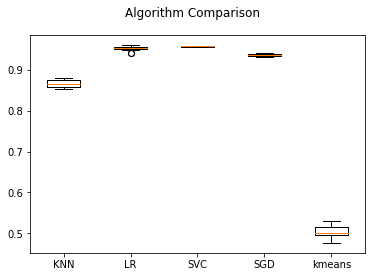

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()